In [2]:
%matplotlib inline
import pandas as pd 
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import missingno as msno
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D

foodSep = {'ACCESS':pd.DataFrame, 'STORES':pd.DataFrame, 'RESTAURANTS':pd.DataFrame,'ASSISTANCE':pd.DataFrame, 
        'INSECURITY':pd.DataFrame, 'PRICES_TAXES':pd.DataFrame,
        'LOCAL':pd.DataFrame, 'HEALTH':pd.DataFrame, 'SOCIOECONOMIC':pd.DataFrame}
for k, n in foodSep.items():
    foodSep[k] = pd.read_csv(k + '.csv')

/home/porrster/home/porrster/Documents/anaconda2/envs/universe/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
foodSep['ACCESS'].head()

,FIPS,State,County,LACCESS_POP10,LACCESS_POP15,PCH_LACCESS_POP_10_15,PCT_LACCESS_POP10,PCT_LACCESS_POP15,LACCESS_LOWI10,LACCESS_LOWI15,...,LACCESS_HISP15,PCT_LACCESS_HISP15,LACCESS_NHASIAN15,PCT_LACCESS_NHASIAN15,LACCESS_NHNA15,PCT_LACCESS_NHNA15,LACCESS_NHPI15,PCT_LACCESS_NHPI15,LACCESS_MULTIR15,PCT_LACCESS_MULTIR15
0,1001,AL,Autauga,18428.439685,17496.693038,-5.056026,33.769657,32.062255,5344.427472,6543.676824,...,471.136164,0.863345,86.767975,0.159000,61.169869,0.112092,8.817961,0.016159,482.848633,0.884808
1,1003,AL,Baldwin,35210.814078,30561.264430,-13.204891,19.318473,16.767489,9952.144027,9886.831137,...,1377.874834,0.755973,212.946378,0.116833,181.649648,0.099662,14.819634,0.008131,1127.696098,0.618712
2,1005,AL,Barbour,5722.305602,6069.523628,6.067799,20.840972,22.105560,3135.676086,2948.790251,...,509.377525,1.855183,17.096410,0.062266,39.960527,0.145539,8.082376,0.029436,462.382655,1.684025
3,1007,AL,Bibb,1044.867327,969.378841,-7.224696,4.559753,4.230324,491.449066,596.162829,...,8.596762,0.037516,1.994318,0.008703,2.513097,0.010967,0.000000,0.000000,5.259244,0.022951
4,1009,AL,Blount,1548.175559,3724.428242,140.568857,2.700840,6.497380,609.027708,1650.959482,...,497.489891,0.867886,8.428994,0.014705,28.938242,0.050484,1.062851,0.001854,202.914187,0.353990


In [4]:
#combine all separate categories into one dataframe
# for simplicity. All categories have same number of rows
food = pd.concat(foodSep, axis=1)

In [5]:
#confirm combination
print(foodSep['ACCESS'].shape)
print(food.shape)

(3143, 44)
(3143, 304)


In [6]:
food.describe()

ACCESS                                                      \
               FIPS  LACCESS_POP10  LACCESS_POP15 PCH_LACCESS_POP_10_15   
count   3143.000000    3143.000000    3124.000000          3.117000e+03   
mean   30390.411709   20156.653242   19287.747386          7.180008e+03   
std    15164.717720   51308.865791   47803.525596          3.955676e+05   
min     1001.000000       0.000000       0.000000         -1.000000e+02   
25%    18178.000000    1661.076794    1631.358726         -1.091343e+01   
50%    29177.000000    4097.827186    4131.174278         -6.239322e-02   
75%    45082.000000   12954.123206   13119.029389          7.262080e+00   
max    56045.000000  886068.668386  740267.412661          2.208376e+07   

                                                                         \
      PCT_LACCESS_POP10 PCT_LACCESS_POP15 LACCESS_LOWI10 LACCESS_LOWI15   
count       3143.000000       3124.000000    3143.000000    3123.000000   
mean          23.559330         23.084470    5551.776559    5833.959524   
std           20.250176         19.602745   13862.922934   13989.348252   
min            0.000000          0.000000       0.000000       0.000000   
25%           10.847099         10.927326     592.983070     608.235919   
50%           19.685956         19.200682    1500.780036    1636.858816   
75%           29.581054         28.862231    4591.067541    4859.016156   
max          100.000001        100.000001  292541.789025  259479.516033   

                                                       ...         \
      PCH_LACCESS_LOWI_10_15 PCT_LACCESS_LOWI10        ...          
count           3.115000e+03        3143.000000        ...          
mean            7.318957e+03           8.374953        ...          
std             4.004692e+05           8.214988        ...          
min            -1.000000e+02           0.000000        ...          
25%            -1.232638e+01           3.442171        ...          
50%             3.486028e+00           6.150772        ...          
75%             2.352342e+01          10.324935        ...          
max             2.234893e+07          72.274456        ...          

               STORES                                               \
      PCH_SNAPS_12_16   SNAPSPTH12   SNAPSPTH16 PCH_SNAPSPTH_12_16   
count     3140.000000  3143.000000  3141.000000        3138.000000   
mean        19.774565     0.880064     1.025253          20.079051   
std         32.074488     0.387638     0.451670          39.262939   
min       -100.000000     0.000000     0.000000        -100.000000   
25%          5.405406     0.629603     0.750265           5.136099   
50%         15.915190     0.818400     0.965336          15.206350   
75%         28.979172     1.066786     1.234080          28.328855   
max       1100.000000     6.658001     6.695621        1135.312012   

                                                                          \
            WICS08       WICS12 PCH_WICS_08_12    WICSPTH08    WICSPTH12   
count  3143.000000  3143.000000    3124.000000  3143.000000  3143.000000   
mean     14.371619    15.109131      -1.901222     0.255593     0.230473   
std      49.856567    55.831489      25.937208     0.257250     0.211762   
min       0.000000     0.000000    -100.000000     0.000000     0.000000   
25%       3.000000     3.000000     -12.500000     0.123272     0.118920   
50%       5.000000     5.000000       0.000000     0.189785     0.177336   
75%      11.000000    11.000000       0.000000     0.296110     0.268129   
max    1285.000000  1602.000000     300.000000     4.618937     2.994012   

                         
      PCH_WICSPTH_08_12  
count       3124.000000  
mean          -3.995745  
std           25.580415  
min         -100.000000  
25%          -15.333640  
50%           -2.383872  
75%            3.158470  
max          294.070300  

[8 rows x 286 columns]

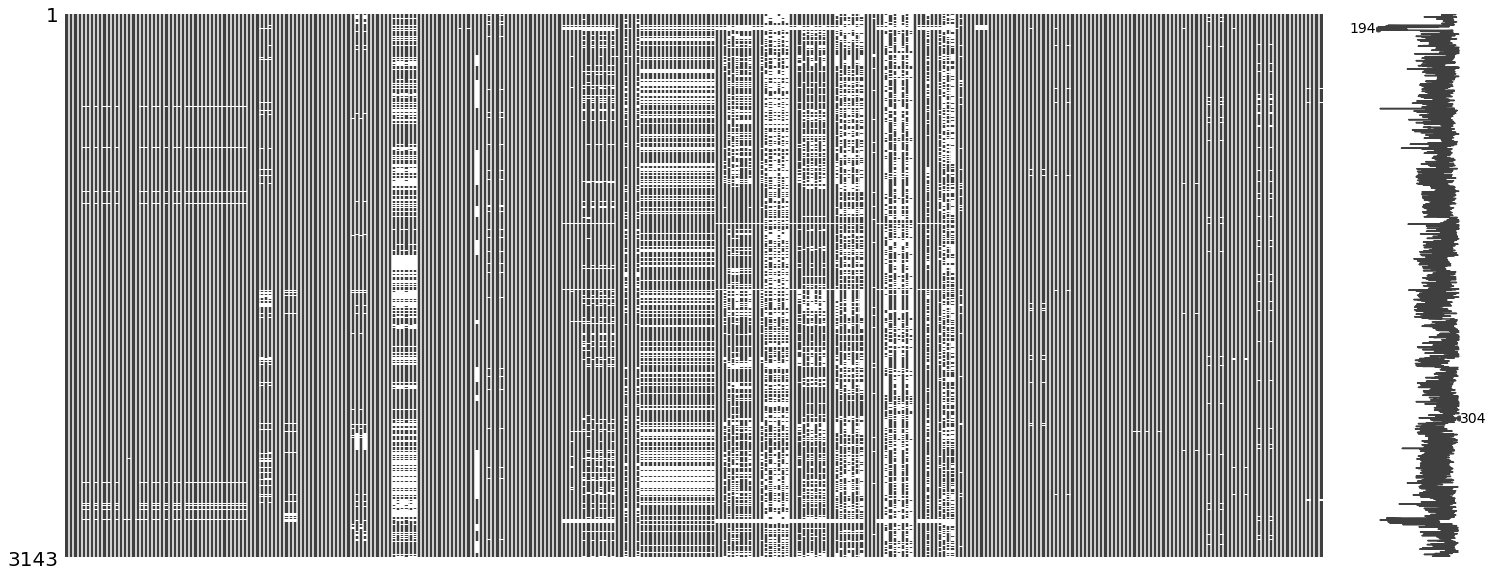

In [7]:
msno.matrix(food)

In [8]:
#Lets remove categories which have too much missing information,
# here we removed all columns with more than 200 missing values

In [9]:
food_clean = food[[x[0] for x in food.items() if sum(pd.isnull(food[x[0]])) < 200]]
food_clean.shape

(3143, 224)

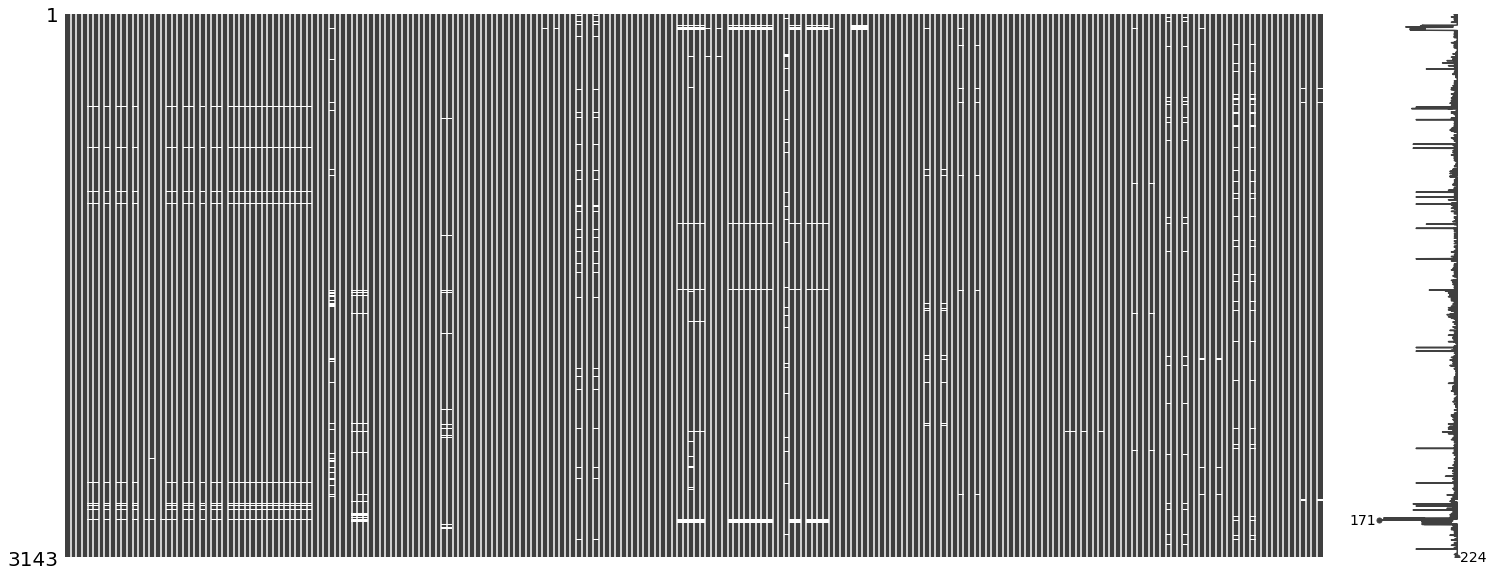

In [10]:
msno.matrix(food_clean)

In [11]:
# now lets remove rows with particularly large numbers of missing values
print(sum(sum(pd.isnull([food_clean[x[0]] for x in food_clean.items()]))))
for i, row in food_clean.iterrows():
    if sum(pd.isnull(row)) > 25:
        food_clean = food_clean.drop(i)
print(food_clean.shape)
print(sum(sum(pd.isnull([food_clean[x[0]] for x in food_clean.items()]))))

3942
(3115, 224)
3064


In [12]:
#Replace missing values with average for category.
# logic is that since the missing values make up such a
# small part of the dataset (about .4%), it would not 
# skew the results too much, while still retaining a large
# amount of data that would have been lost had we simply removed 
# the entire rows

In [13]:
#Need to correct key index values because we dropped rows
# (ex. [0:"foo", 1:'foo', 2:'foo'] >*drop item 1*> [0:'foo', 2:'foo'], <- need to correct)
food_clean = food_clean.assign(index = range(len(food_clean[('ACCESS', 'LACCESS_POP10')])))
food_clean = food_clean.set_index('index')
food_clean.drop('index', axis=1)

for index, (k, a) in enumerate(food_clean.items()):
    #skip over first three categories
    if sum(pd.isnull(a)) != 0 and index > 2:
        average = 0
        for num, val in a.items():
            if not pd.isnull(val):
                average += val 
        average /= (len(a) - sum(pd.isnull(a)))
        for i in range(len(a)):
            if pd.isnull(a[i]):
                a[i] = average
        food_clean[k] = a

/home/porrster/home/porrster/Documents/anaconda2/envs/universe/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


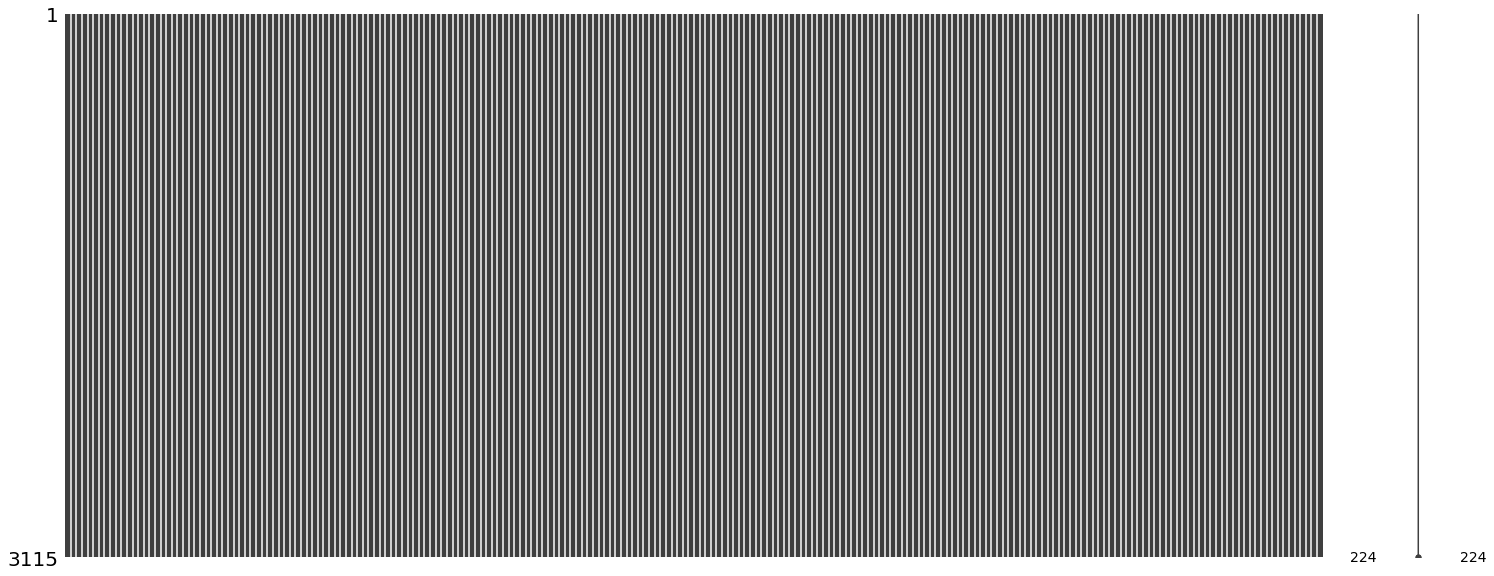

In [14]:
msno.matrix(food_clean) #Now we have a clean dataset :) 

In [15]:
#Now lets try to calculate farm to school program using logistic
# regression
def sigmoid(X, w):
    """
    Compute the elementwise sigmoid of the product Xw
    Data in X should be rows, weights are a column. 
    """
    return 1 / (1 + np.exp(-np.dot(X, w)))

def gradient(X, y, w, onept, lamb=0):
    """
    Compute gradient of regularized loss function. 
    Accomodate for if X is just one data point. 
    """
    if onept: 
        return 2 * lamb * w - ((y - sigmoid(X, w)) * X).reshape(w.size, 1)
    return 2 * lamb * w - np.dot(X.T, y - sigmoid(X, w)) / y.size

def loss(X, y, w, lamb=0):
    """
    Compute total loss for the data in X, labels in y, params w
    """
    sumcost = 0
    for i in range(X.shape[0]):
        sumcost += y[i] * np.log(sigmoid(X[i], w)) + (1 - y[i]) * np.log(1 - sigmoid(X[i], w))
    return lamb * np.linalg.norm(w)**2 - sumcost / y.size

def accuracy(X, y, w):
    """
    Compute accuracy for data in X, labels in y, params w
    """
    results = np.round(sigmoid(X, w))
    score = sum([results[i] == y[i] for i in range(y.size)]) / y.size
    return score[0]

In [16]:
#Using variables we deemed relevant to the variable we're trying to predict. Number of farmers markets because
# it indicates that farmers are selling locally. Farms with direct sales because it would directly affect 
# the ability to support a farm to school program. Low access to stores and low income may make a school more 
# likely to participate in farm to school program. Food insecurity would indicate a need for better food sources,
# which may prompt engagement in the farm to school program.
half = len(food_clean[('LOCAL', 'FMRKT09')]) // 2
food_train = food_clean[0:half]
food_val = food_clean[half:]

datTrain = food_train[[('LOCAL', 'FMRKT09'), ('LOCAL', 'PCT_LOCLFARM07'), ('ACCESS', 'PCT_LACCESS_LOWI10'),
            ('INSECURITY', 'FOODINSEC_10_12')]]
datVal = food_val[[('LOCAL', 'FMRKT09'), ('LOCAL', 'PCT_LOCLFARM07'), ('ACCESS', 'PCT_LACCESS_LOWI10'),
            ('INSECURITY', 'FOODINSEC_10_12')]]
#Need to get dataset into 2D np array format to be comnpatible with the functions we use
logTrain = np.zeros((len(datTrain[('LOCAL', 'FMRKT09')]), 4))
logVal = np.zeros((len(datVal[('LOCAL', 'FMRKT09')]), 4))

for i, row in datTrain.iterrows():
    logTrain[i] = [row[x] for x in range(len(row))]
for i, row in datVal.iterrows():
    logVal[i - half] = [row[x] for x in range(len(row))]
    
datTrain = food_train[('LOCAL', 'FARM_TO_SCHOOL09')] #2013 set has too many missing values
datVal = food_val[('LOCAL', 'FARM_TO_SCHOOL09')]

logLabelsTrain = np.zeros(len(datTrain))
logLabelsVal = np.zeros(len(datVal))

for k, a in datTrain.items():
    logLabelsTrain[k] = a
for k, a in datVal.items():
    logLabelsVal[k - half] = a

logTrain = np.concatenate([logTrain, np.ones((logTrain.shape[0], 1))], axis=1)
logVal = np.concatenate([logVal, np.ones((logVal.shape[0], 1))], axis=1)
logTrain.shape

(1557, 5)

In [19]:
weights = np.asarray([np.random.rand() for i in range(logTrain.shape[1])]).reshape(logTrain.shape[1], 1)
weights /= np.linalg.norm(weights)
losses = []
accuracies = []
epsilon = 0.001
num_iterations = 100

for i in range(num_iterations):
    diff = epsilon * gradient(logTrain, logLabelsTrain, weights, False)
    weights = weights - diff
    losses.append(loss(logTrain, logLabelsTrain, weights))
    accuracies.append(accuracy(logTrain, logLabelsTrain, weights))

/home/porrster/home/porrster/Documents/anaconda2/envs/universe/lib/python3.5/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in log
/home/porrster/home/porrster/Documents/anaconda2/envs/universe/lib/python3.5/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in multiply


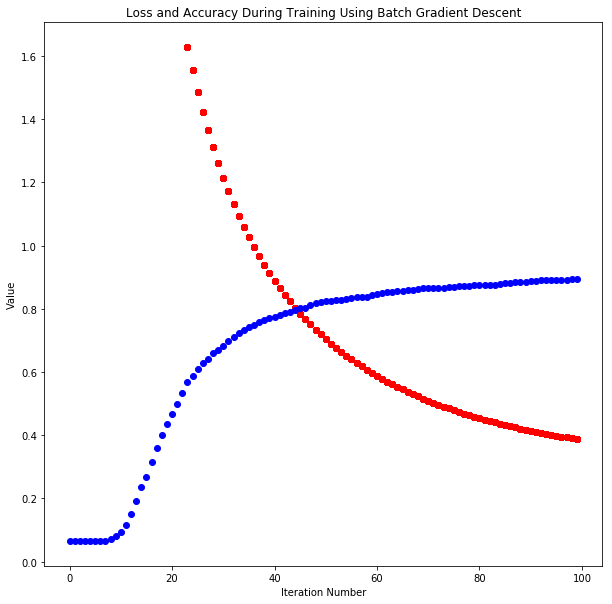

Accuracy for training data: 0.893
Accuracy for validation data: 0.879


In [20]:
#Visual of loss over time
plt.figure(figsize=[10,10])
plt.plot(np.arange(num_iterations), losses, 'ro')
plt.plot(np.arange(num_iterations), accuracies, 'bo')
plt.title('Loss and Accuracy During Training Using Batch Gradient Descent')
plt.ylabel('Value')
plt.xlabel('Iteration Number')
plt.show()
accuracy0 = accuracy(logTrain, logLabelsTrain, weights)
accuracy1 = accuracy(logVal, logLabelsVal, weights)
print("Accuracy for training data: %.3f" % accuracy0)
print("Accuracy for validation data: %.3f" % accuracy1)

In [21]:
# Here we will calculate a linear regression using multiple variables
#to predict adult obeseity rates. We will also use recursive feature
#elimination to remove irrelivant variables

In [22]:
new_filtered = pd.concat([food_clean['STORES']['GROC09'], food_clean['STORES']['CONVS09'], food_clean['RESTAURANTS']['FFR09'],
                food_clean['RESTAURANTS']['FSR09'], food_clean['PRICES_TAXES']['SODATAX_STORES14'],
                food_clean['PRICES_TAXES']['CHIPSTAX_STORES14'], food_clean['HEALTH']['RECFAC09'],
                food_clean['HEALTH']['PCT_OBESE_ADULTS13']], axis=1)
target_filtered = pd.concat([new_filtered['PCT_OBESE_ADULTS13']], axis=1)
regr_dataset = pd.concat([new_filtered['FFR09'], new_filtered['CONVS09'], new_filtered['SODATAX_STORES14'],
                         new_filtered['CHIPSTAX_STORES14'], new_filtered['RECFAC09'], new_filtered['GROC09'],
                         new_filtered['FSR09']], axis=1)

#add bias variable
regr_dataset = sm.add_constant(regr_dataset)

regr_dataset.head()

,const,FFR09,CONVS09,SODATAX_STORES14,CHIPSTAX_STORES14,RECFAC09,GROC09,FSR09
index,,,,,,,,
0,1.0,30,29,4.0,4.0,4,6,34
1,1.0,112,119,4.0,4.0,18,24,202
2,1.0,21,14,4.0,4.0,1,5,12
3,1.0,7,19,4.0,4.0,1,6,6
4,1.0,24,31,4.0,4.0,3,6,19


In [23]:
# Create linear regression object
regr = linear_model.LinearRegression()

#Perform recurrent feature elimation to find most relevant
# variables
myRFE = RFECV(regr, step = 1, cv = 5)
myRFE = myRFE.fit(regr_dataset, target_filtered)

print(myRFE.support_)
print(myRFE.ranking_)

[False False False  True  True  True False False]
[6 2 4 1 1 1 5 3]


/home/porrster/home/porrster/Documents/anaconda2/envs/universe/lib/python3.5/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [24]:
#Create new dataframe based on most relevant variables
regr_dataset = pd.concat([regr_dataset['SODATAX_STORES14'], regr_dataset['CHIPSTAX_STORES14'], 
                          regr_dataset['RECFAC09']], axis=1)
regr_dataset = sm.add_constant(regr_dataset)

In [25]:
# Split the data into training/testing sets
training_set = regr_dataset[:half]
test_set = regr_dataset[half:]
# Split the targets into training/testing sets
target_training_set = target_filtered[:half]
target_test_set = target_filtered[half:]
# Train the model using the training sets
regr = sm.OLS(target_training_set, training_set).fit()
# Make predictions using the testing set
obesity_pred = regr.predict(test_set)

# Some stats about the model
print(regr.summary())
# The coefficients
print('Coefficients: \n', regr.params)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(target_test_set, obesity_pred))

                            OLS Regression Results                            
Dep. Variable:     PCT_OBESE_ADULTS13   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     90.86
Date:                Wed, 04 Oct 2017   Prob (F-statistic):           3.59e-54
Time:                        01:32:05   Log-Likelihood:                -4545.2
No. Observations:                1557   AIC:                             9098.
Df Residuals:                    1553   BIC:                             9120.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                32.0309      0.20

In [26]:
# Here we are going to predict levels of poverty rates based on levels of obesity.
#This will provide some insight on the connection between health and 
#social status.
dat = food_clean[[('HEALTH', 'PCT_OBESE_ADULTS13'), ('HEALTH', 'PCT_DIABETES_ADULTS13')]]
poverty = food_clean[('SOCIOECONOMIC','POVRATE15')] 
#Add constant 
dat = sm.add_constant(dat)

In [27]:
#Split into training and validation sets
dat_train = dat[0:half]
dat_val = dat[half:]

labels_train = poverty[0:half]
labels_val = poverty[half:]

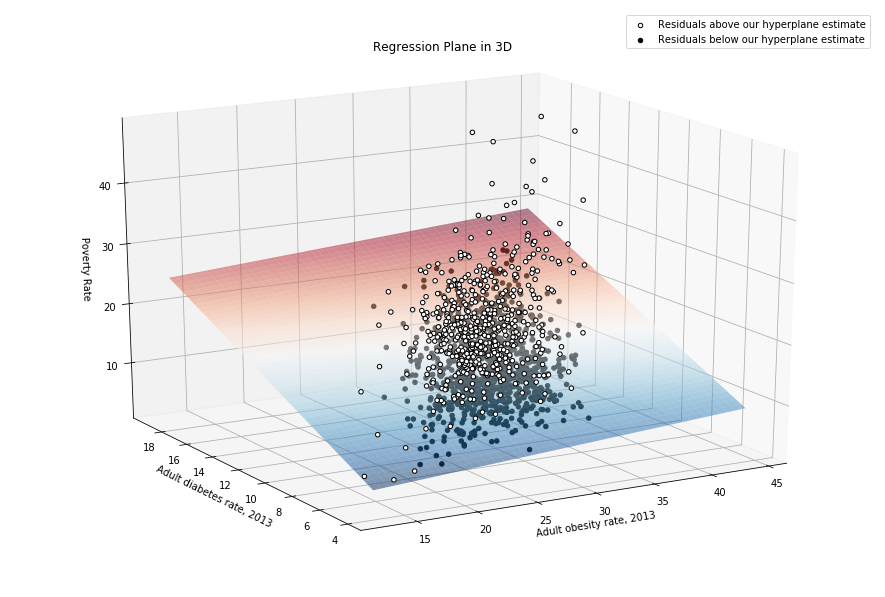

In [28]:
# Let's take a look at Diabetes vs Poverty
myMLR = sm.OLS(labels_train, dat_train).fit()
#Make some predictions
prediction = myMLR.predict(dat_val)

#Make a visual model
obese = ('HEALTH', 'PCT_OBESE_ADULTS13')
diab = ('HEALTH', 'PCT_DIABETES_ADULTS13')
x1, x2 = np.meshgrid(np.linspace(dat_val[obese].min(), dat_val[obese].max(), 100), 
                       np.linspace(dat_val[diab].min(), dat_val[diab].max(), 100))
x3 = myMLR.params[0] + myMLR.params[1] * x1 + myMLR.params[2] * x2
#Create figure
fig = plt.figure(figsize=(12, 8))
my3D = Axes3D(fig, azim=-120, elev=20)
#Plot the plane
surf = my3D.plot_surface(x1, x2, x3, cmap=plt.cm.RdBu_r, alpha=0.5, linewidth=0.5)
#Plot data points
resid = labels_val - prediction
my3D.scatter(dat_val[resid >= 0][obese], dat_val[resid >= 0][diab], labels_val[resid >= 0], color='black', alpha=1.0, facecolor='white',
            label="Residuals above our hyperplane estimate")
my3D.scatter(dat_val[resid < 0][obese], dat_val[resid < 0][diab], labels_val[resid < 0], color='black', alpha=1.0,
            label="Residuals below our hyperplane estimate")
# set axis labels
my3D.set_xlabel('Adult obesity rate, 2013')
my3D.set_ylabel('Adult diabetes rate, 2013')
my3D.set_zlabel('Poverty Rate')
my3D.set_title('Regression Plane in 3D')
my3D.legend()

plt.show()

In [29]:
#Now lets calculate some stats.
mse = 1/len(prediction) * np.dot((labels_val.T - prediction.T), (labels_val - prediction))
print(mse)

27.0901878236
